# How to use this notebook:

At first, there will be a lot of code cluttering things up. To hide of the code, at the top of the page click Kernal --> Restart and Run All. This will run the program and now you will have the ability to toggle on/off the raw code.

In [1]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import math
from scipy import stats
import glob
from scipy.interpolate import interp1d
import mplcursors
%matplotlib inline
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import HTML, display
import IPython

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
ML_disk, ML_bulge, DM_frac, SB_bary,  Ltot, HImass, Vflat, index_stop = np.loadtxt('data for good galaxies.csv', delimiter=',', skiprows = 1, usecols = (1,2,3,5,14,20,22,24),unpack = True)
Lbulge  = np.loadtxt('sparc global measurements.csv', delimiter=',', unpack = True, skiprows = 2, usecols = (20)) 
sparc = np.load('sparc_dict.npy').item()
name = np.loadtxt('starkman data.csv', delimiter=',', skiprows = 2, usecols = (0), dtype = 'object', unpack = True)
rad_start, rad_stop = np.loadtxt('bracketing curves.csv', delimiter=',', skiprows = 1, usecols = (3,4),unpack = True)

Ltot, Lbulge, HImass = Ltot*1e9, Lbulge*1e9, HImass*1e9


In [3]:
len_tot = 116
Rp_arr = np.empty(len_tot) #stores Rp
DM_frac = np.empty(len_tot) #stores fraction of galaxies which are DM by mass
SB_bary = np.empty(len_tot) #stores baryonic surface brightness
Mbary_arr  = np.empty(len_tot) #stores baryonic mass of galaxy
ML_disk  = np.full(len_tot, 0.5)
ML_bulge  = np.full(len_tot, 0.7)
Vp_baryarr = np.empty(len_tot) #stores Vp of baryonic rotation curve
Vp_obsarr = np.empty(len_tot) #stores Vp of observed rotation curve
index_peakarr = np.empty(len_tot) #stores the array index of Rp
index_stoparr = np.empty(len_tot) #stores the array index of the upper bracket for finding Rp
Lnew =np.empty(len_tot) #stores luminosities with new M/L's

In [22]:
def interpolation(gal_name, mult_factor, start, stop):
    
    #define new M/L ratios:
    ML_disknew, ML_bulgenew = 0.5*mult_factor, 0.7*mult_factor
   
    #v_bary calculated in quadrature:
    vbary = np.sqrt(ML_disknew * sparc[gal_name+"_Vdisk"]**2 + ML_bulgenew * sparc[gal_name+"_Vbul"]**2 + sparc[gal_name+"_Vgas"]**2 )

    #creating interpolations of the baryonic and observed curves:
    interp_vobs = interp.UnivariateSpline(sparc[gal_name+"_rad"], sparc[gal_name+'_Vobs'])
    radius_vals = np.linspace(sparc[gal_name+"_rad"].min(), sparc[gal_name+"_rad"].max(), 1000)
    interp_vbary = interp.UnivariateSpline(sparc[gal_name+"_rad"], vbary)
    
    #to make finding Rp easier, I recorded upper and lower limits of the radius where it'd be. Below, I'm just
    # finding the indices associated with those upper/lower radii
    index_start =np.argmin(np.abs(start - radius_vals))
    index_stop = np.argmin(np.abs(stop - radius_vals))
    index_peak = index_start + np.argmax(interp_vbary(radius_vals)[index_start:index_stop])#np.argmin(np.abs(interp_vbaryderiv))#
    
    #defining Rp, Vp etc based on putting the peak index (index_peak) in interpolation formulas:
    Rp = radius_vals[index_peak]
    Rp_arr[sparc[gal_name+"_index"]] = Rp
    Vp_bary = interp_vbary(Rp)
    Vp_obs = interp_vobs(Rp)
    
    #just adding everything to a dictionary for  easy access later
    DM_frac[sparc[gal_name+"_index"]] = (Vp_obs - Vp_bary)/Vp_obs
    SB_bary[sparc[gal_name+"_index"]]  = (3/4) * (Mbary_arr[sparc[gal_name+"_index"]]/Rp**2)#
    Vp_baryarr[sparc[gal_name+"_index"]] = Vp_bary
    Vp_obsarr[sparc[gal_name+"_index"]] = Vp_obs
    index_peakarr[sparc[gal_name+"_index"]] = index_peak
    index_stoparr[sparc[gal_name+"_index"]] = index_stop
    
    #calculating luminosities of gas, bulge, disk from the new M/L ratios and adding them for total luminosity
    Lgas = HImass[sparc[gal_name+"_index"]] * (1/1.33)
    Lbulgenew = ML_bulge[sparc[gal_name+"_index"]]*(ML_bulge[sparc[gal_name+"_index"]]/ML_bulgenew)
    Ldisknew = (Ltot[sparc[gal_name+"_index"]] - Lbulge[sparc[gal_name+"_index"]] - Lgas)*(ML_disk[sparc[gal_name+"_index"]]/ML_disknew)
    Lnew[sparc[gal_name+"_index"]] = Lgas + Ldisknew + Lbulgenew
        

Below, `mult_factor` represents the factor by which the mass to light ratios of the bulge and disk (initially set at 0.7 and 0.5, respectively) are multiplied. For example, setting the slider value to 2 would set $\Upsilon_{bulge}=1.4, \Upsilon_{disk}=1$. The diagonal dashed line represents a dlog(V)/dlog(R) of -0.5, which was predicted in [Courteau & Rix (1999)](https://iopscience.iop.org/article/10.1086/306872/meta). However, as playing with the slider shows, the slope doesn't reach nearly that level of steepness.

The minimum value of the slider is 0.77 because below that, the values of luminosities can become negative.

In [20]:
def ML_linear(mult_factor):
    ML_disknew = 0.5 * mult_factor
    ML_bulgenew = 0.7 * mult_factor

    lum_orig = Ltot #using original M/L
    lum_new = Lnew

    ##Vobs
    coeff,cov=np.polyfit(np.log10(lum_new), np.log10(Vp_obsarr),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(lum_orig)),max(np.log10(lum_orig)),1000)
    polynomial=np.poly1d(coeff)

    delt_Vnew = np.log10(Vp_obsarr) - (coeff[0]*np.log10(lum_orig) + coeff[1]) #delt_v = Vp_obs - (mx+b) where m,b solved in best fit line

    ## Rp
    coeff,cov=np.polyfit(np.log10(lum_new), np.log10(Rp_arr),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(lum_orig)),max(np.log10(lum_orig)),1000)
    polynomial=np.poly1d(coeff)

    delt_Rnew = np.log10(Rp_arr) - (coeff[0]*np.log10(lum_orig) + coeff[1])
    
    
    plt.figure(figsize=(12,10))
    
    goodvals = np.where((Vp_obsarr > Vp_baryarr) & (index_peakarr < index_stoparr))
    plt.scatter(delt_Rnew[goodvals], delt_Vnew[goodvals], c =DM_frac[goodvals], cmap=plt.cm.get_cmap('plasma_r'))
    plt.colorbar().set_label("DM fraction")
    plt.axis('equal')
    plt.xlabel('d log(Rp)', fontsize = 'large')
    plt.ylabel('d log(V)', fontsize = 'large')

    coeff,cov=np.polyfit(delt_Rnew[goodvals], delt_Vnew[goodvals],1,cov=True)
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(delt_Rnew[goodvals]),max(delt_Rnew[goodvals]),1000)
    polynomial=np.poly1d(coeff)
    plt.plot(xfit,polynomial(xfit),color='green')
    print('    slope = {:.6f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))

    plt.plot(xfit, xfit*-.5, ls = ':')
    plt.axhline(ls = ':')
    
    return coeff[0],coeff_err[0]                                                                           
                                                                              

In [14]:
def other_plots(): #creates the two bottom plots after slider

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))


    print('modified M/L = original M/L * mult_factor')

    lum_orig = Ltot #using original M/L
    lum_new = Lnew #using new M/L with changes applied

    ##Vobs
    ax1.scatter(np.log10(lum_orig), np.log10(Vp_obsarr),alpha=0.5, label = 'original M/L')
    ax1.scatter(np.log10(lum_new), np.log10(Vp_obsarr), alpha=0.5, label = ('M/L * mult_factor'))
    ax1.set_xlabel('log(L) [Lsun]', fontsize = 'large')
    ax1.set_ylabel('log(Vobs) [km/s]', fontsize = 'large')
    ax1.legend()

    coeff,cov=np.polyfit(np.log10(lum_orig), np.log10(Vp_obsarr),1,cov=True) #creating best-fit line from original data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(lum_orig)),max(np.log10(lum_orig)),1000)
    polynomial=np.poly1d(coeff)
    ax1.plot(xfit,polynomial(xfit),color='blue', alpha=.5)
    print(' \n  with original M/L: dV/dL = {:.3f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))

    coeff,cov=np.polyfit(np.log10(lum_new), np.log10(Vp_obsarr),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(lum_orig)),max(np.log10(lum_orig)),1000)
    polynomial=np.poly1d(coeff)
    ax1.plot(xfit,polynomial(xfit),color='orange')
    print('  with modified M/L: dV/dL = {:.3f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))

    delt_Vnew = np.log10(Vp_obsarr) - (coeff[0]*np.log10(lum_orig) + coeff[1]) #delt_v = Vp_obs - (mx+b) where m,b solved in best fit line

    ## Rp
    ax2.scatter(np.log10(lum_orig), np.log10(Rp_arr),alpha=0.5, label = 'original M/L')
    ax2.scatter(np.log10(lum_new), np.log10(Rp_arr), alpha=0.5,label = ('M/L * mult_factor'))
    ax2.set_xlabel('log(L) [Lsun]', fontsize = 'large')
    ax2.set_ylabel('log(Rp) [kpc]', fontsize = 'large')
    ax2.legend()

    coeff,cov=np.polyfit(np.log10(lum_orig), np.log10(Rp_arr),1,cov=True) #creating best-fit line from original data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(lum_orig)),max(np.log10(lum_orig)),1000)
    polynomial=np.poly1d(coeff)
    ax2.plot(xfit,polynomial(xfit),color='blue', alpha=.5)
    print(' \n  with original M/L: dR/dL = {:.3f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))

    coeff,cov=np.polyfit(np.log10(lum_new), np.log10(Rp_arr),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(lum_orig)),max(np.log10(lum_orig)),1000)
    polynomial=np.poly1d(coeff)
    ax2.plot(xfit,polynomial(xfit),color='orange')
    print('  with modified M/L: dR/dL = {:.3f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))
    #print(delt_Vnew, delt_Rnew)

    delt_Rnew = np.log10(Rp_arr) - (coeff[0]*np.log10(lum_orig) + coeff[1])


In [21]:
# def dVdR():
#     for x in range(len(name)):
#          interpolation(name[x], np.exp(-2/(1*Rp_arr[x])), rad_start[x], rad_stop[x])
#     ML_linear(np.exp(-2/(1*Rp_arr)))
# dVdR()

def dVdR(mult_factor):
    for x in range(len(name)):
        interpolation(name[x], mult_factor, rad_start[x], rad_stop[x])
    slope, slope_err = ML_linear(mult_factor)
    return slope, slope_err

interact(dVdR, mult_factor=widgets.FloatSlider(value=1, min=0.77, max=4,step=0.01, continuous_update=False)) 


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='mult_factor', max=4.0, min=…

<function __main__.dVdR(mult_factor)>

The graphs below provide a little more insight into the graph above. On the left, I have graphed V vs. L (effectively Tully-Fisher) using both the original and new M/L, and fitted best-fit lines for each. The same is done on the right, except with Rp vs. L. The dlog(V) and dlog(R) values above are found by calculating the distance between the velocity of a point and the velocity of its corresponding place on the best-fit line, keeping the same luminosity value. 

Although the above graph updates automatically with changing M/L, you must click the "press to reload" button to update the graphs below. 

modified M/L = original M/L * mult_factor
 
  with original M/L: dV/dL = 0.254 +/- 0.009
  with modified M/L: dV/dL = 0.302 +/- 0.010
 
  with original M/L: dR/dL = 0.115 +/- 0.027
  with modified M/L: dR/dL = 0.159 +/- 0.032


Button(description='press to reload', style=ButtonStyle())

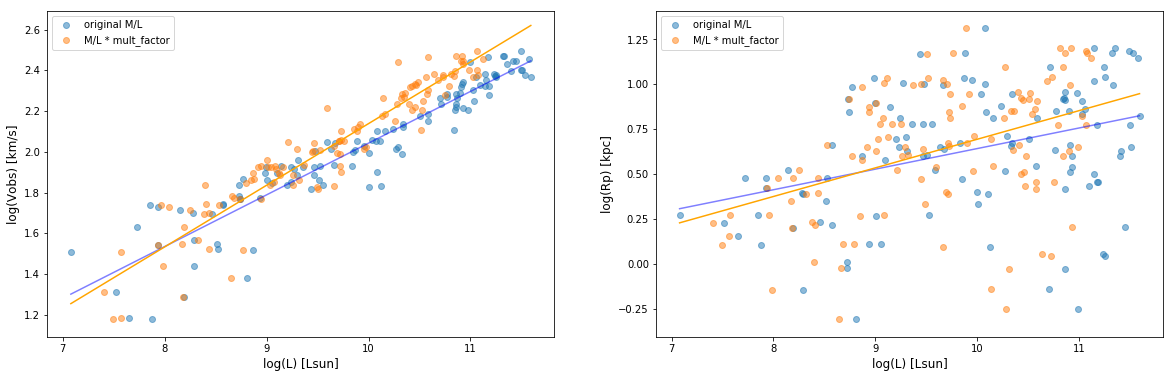

In [17]:
def on_button_clicked(b):
    IPython.display.clear_output()
    other_plots()
    display(button)

button = widgets.Button(description="press to reload")
display(button)
button.on_click(on_button_clicked)